In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from libutil import out_dir
from dotenv import load_dotenv; load_dotenv()

import warnings
warnings.filterwarnings("ignore")

In [17]:
datasets = [
    "rcv1",
    "webkb",
    "spamassassin",
    "avila",
    "smartphone",
    "swarm",
    "sensorless",
    "splice",
    "anuran"
]

In [18]:
def read_stopping(name):
    file = f"{out_dir()}/stopping/{name}__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=l__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)

In [19]:
# this is 10 runs on svm-linear, initial set size 10, no data modification
# None indicates a condition failed to stop
results = {}
for name in datasets:
    results[name] = read_stopping(name)

`results` has the format:

    Dataset name ->

        Stopping condition name ->

            Array of 10 runs ->

                Four tuple of:

                    Number of instances labelled

                    Accuracy at stopping point

                    f1 score at stopping point

                    roc auc score at stopping point
                

If the condition did not stop on a particular run all values are `None`

In [20]:
to_plot = [
    #'uncertainty_min',
    'SC_entropy_mcs',
    #'SC_oracle_acc_mcs',
    'SC_mes',
    'EVM',
    'stabilizing_predictions',
    'VM',
    'SSNCut',
    'GOAL',
    'SC_oracle_acc',
    'Stabilizing Predictions',
    'Performance Convergence',
    'Uncertainty Convergence',
    'Max Confidence',
    'Contradictory Information',
    'Classification Change',
    'Overall Uncertainty'
]
results_filter = {dataset: {name: results for name, results in conds.items() if name in to_plot} for dataset, conds in results.items()}

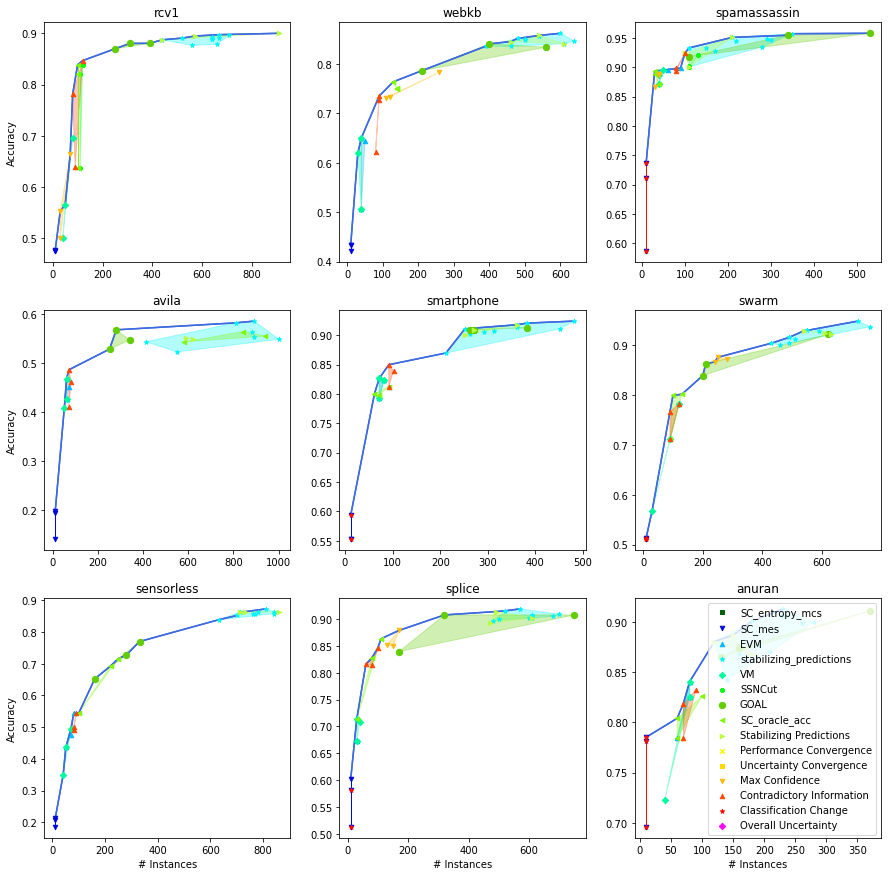

In [21]:
from importlib import reload; import libplot; reload(libplot); from libplot import plot_paraeto_hull
plot_paraeto_hull(results_filter)